# PA Quantum Neuron

Build a classical neuron with a quantum circuit

In [6]:
from colorama import Fore, Back, Style 

import numpy as numpy
from pennylane import numpy as np
import pennylane as qml
from pennylane.optimize import NesterovMomentumOptimizer
from pennylane.math import requires_grad

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

from math import pi


# Quantum

In [7]:
max_iterations = 400
loop_count = 13

In [8]:

dev_1 = qml.device('default.qubit', wires=1)
dev_2 = qml.device('default.qubit', wires=1)
dev_3 = qml.device('default.qubit', wires=1)

## Classifier 1
weights_count = 3
init_weights_1 = (0.01 * np.random.randn(weights_count), 0.0)

print(init_weights_1)

@qml.qnode(dev_1)
def circuit_1(weights, data):
    qml.RY(data[0], wires=0) # input feature 1
    qml.RY(data[1], wires=0) # input feature 2
    qml.Rot(weights[0], weights[1], weights[2], wires=0) # weight 1
    
    return qml.expval(qml.PauliZ(0))

def vc_classifier_1(var, data):
    weights = var[0]
    bias = var[1]
    return circuit_1(weights, data) + bias


## Classifier 2
weights_count = 6
init_weights_2 = (0.01 * np.random.randn(weights_count), 0.0)

@qml.qnode(dev_2)
def circuit_2(weights, data):
    qml.RY(data[0], wires=0) # input feature 1
    qml.Rot(weights[0], weights[1], weights[2], wires=0) # weight 1
    
    qml.RY(data[1], wires=0) # input feature 2
    qml.Rot(weights[3], weights[4], weights[5], wires=0) # weight 2

    return qml.expval(qml.PauliZ(0))

def vc_classifier_2(var, data):
    weights = var[0]
    bias = var[1]
    return circuit_2(weights, data) + bias
  

## Classifier 3
weights_count = 6
init_weights_3 = (0.01 * np.random.randn(weights_count), 0.0)

@qml.qnode(dev_3)
def circuit_3(weights, data):
    qml.RY(data[0], wires=0) # input feature 1
    qml.Rot(weights[0], weights[1], weights[2], wires=0) # weight 1
    
    qml.RX(data[1], wires=0) # input feature 2
    qml.Rot(weights[3], weights[4], weights[5], wires=0) # weight 2
    
    return qml.expval(qml.PauliZ(0))

def vc_classifier_3(var, data):
    weights = var[0]
    bias = var[1]
    return circuit_3(weights, data) + bias


## generic
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2
    loss = loss / len(labels)
    return loss

def cost(vc_classifier, weights, datas, labels):
    predictions = [vc_classifier(weights, f) for f in datas]
    return square_loss(labels, predictions)

def accuracy(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)
    return loss
  
def plot_costs(costs, num_layers):
  # plot costs
   fig, (ax1) = plt.subplots(1)
   fig.suptitle('Costs')
   ax1.plot(range(len(costs)), costs, label='Layers: {}'.format(num_layers))
   ax1.set_xlabel('iteration number')
   ax1.set_ylabel('cost objective function')
   ax1.legend(loc="upper right")
   plt.show()

# init weights
# var_init = (0.01 * np.random.randn(1, 2, 3), 0.0)


(tensor([ 0.01899128, -0.00327046, -0.01260198], requires_grad=True), 0.0)


In [9]:
def vc_quantum(vc_classifier, init_weights, x_train, x_test, X, y_train, y_test, Y):
  opt = NesterovMomentumOptimizer(0.01)
  batch_size = 5
  var = init_weights
  iterations = max_iterations
  costs = np.zeros(iterations) 

  for it in range(iterations):

      # Update the weights by one optimizer step
      batch_index = np.random.randint(0, len(x_train), (batch_size,))
      feats_train_batch = x_train[batch_index]
      Y_train_batch = y_train[batch_index]
      var, stepCost = opt.step_and_cost(lambda v: cost(vc_classifier, v, feats_train_batch, Y_train_batch), var)
      # print("trained weights and bias (var):", var)

      # Compute predictions on train and validation set
      predictions_train = [np.sign(vc_classifier(var, f)) for f in x_train]
      predictions_val = [np.sign(vc_classifier(var, f)) for f in x_test]
      predictions_all = [np.sign(vc_classifier(var, f)) for f in X]

      # Compute accuracy on train and validation set
      acc_train = accuracy(y_train, predictions_train)
      acc_val = accuracy(y_test, predictions_val)
      acc_all = accuracy(Y, predictions_all)

      # gather informations for plotting
      costs[it] = cost(vc_classifier, var, X, Y)

      print(
          "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc val: {:0.7f} | Acc all: {:0.7f} "
          "".format(it + 1, costs[it], acc_train, acc_val, acc_all)
      )
  
  return [var, acc_val]

# plot costs
# plot_costs(costs, 0)

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.7047315 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.6480093 | Acc train: 0.5066667 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.5626645 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5100000 
Iter:     4 | Cost: 1.4691716 | Acc train: 0.5333333 | Acc val: 0.5200000 | Acc all: 0.5200000 
Iter:     5 | Cost: 1.3723012 | Acc train: 0.5333333 | Acc val: 0.5200000 | Acc all: 0.5200000 
Iter:     6 | Cost: 1.2684555 | Acc train: 0.5600000 | Acc val: 0.6000000 | Acc all: 0.5500000 
Iter:     7 | Cost: 1.1549162 | Acc train: 0.5733333 | Acc val: 0.6000000 | Acc all: 0.5600000 
Iter:     8 | Cost: 1.0427137 | Acc train: 0.5866667 | Acc val: 0.6800000 | Acc all: 0.5800000 
Iter:     9 | Cost: 0.9515781 | Acc train: 0.6266667 | Acc val: 0.6800000 | Acc all: 0.6200000 
Iter:    10 | Cost: 0.8761885 | Acc train: 0.6000000 | Acc val: 0.6800000 | Acc all: 0.6100000 
Iter:    11 | Cost: 0.8055779 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.3979722 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.3542294 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     3 | Cost: 1.3122640 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     4 | Cost: 1.2617003 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     5 | Cost: 1.1779138 | Acc train: 0.5600000 | Acc val: 0.5600000 | Acc all: 0.5600000 
Iter:     6 | Cost: 1.1045422 | Acc train: 0.5600000 | Acc val: 0.6400000 | Acc all: 0.5700000 
Iter:     7 | Cost: 1.0416142 | Acc train: 0.5866667 | Acc val: 0.6400000 | Acc all: 0.5900000 
Iter:     8 | Cost: 0.9880410 | Acc train: 0.6133333 | Acc val: 0.6800000 | Acc all: 0.6000000 
Iter:     9 | Cost: 0.9451541 | Acc train: 0.6266667 | Acc val: 0.6800000 | Acc all: 0.6200000 
Iter:    10 | Cost: 0.9129219 | Acc train: 0.6533333 | Acc val: 0.7200000 | Acc all: 0.6400000 
Iter:    11 | Cost: 0.8901766 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6706168 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.6314758 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.5411542 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.4690266 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     5 | Cost: 1.3976275 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     6 | Cost: 1.3101570 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     7 | Cost: 1.2259154 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     8 | Cost: 1.1642686 | Acc train: 0.5333333 | Acc val: 0.6000000 | Acc all: 0.5300000 
Iter:     9 | Cost: 1.1005255 | Acc train: 0.5466667 | Acc val: 0.6000000 | Acc all: 0.5400000 
Iter:    10 | Cost: 1.0461043 | Acc train: 0.5600000 | Acc val: 0.5200000 | Acc all: 0.5400000 
Iter:    11 | Cost: 1.0132562 | Acc trai

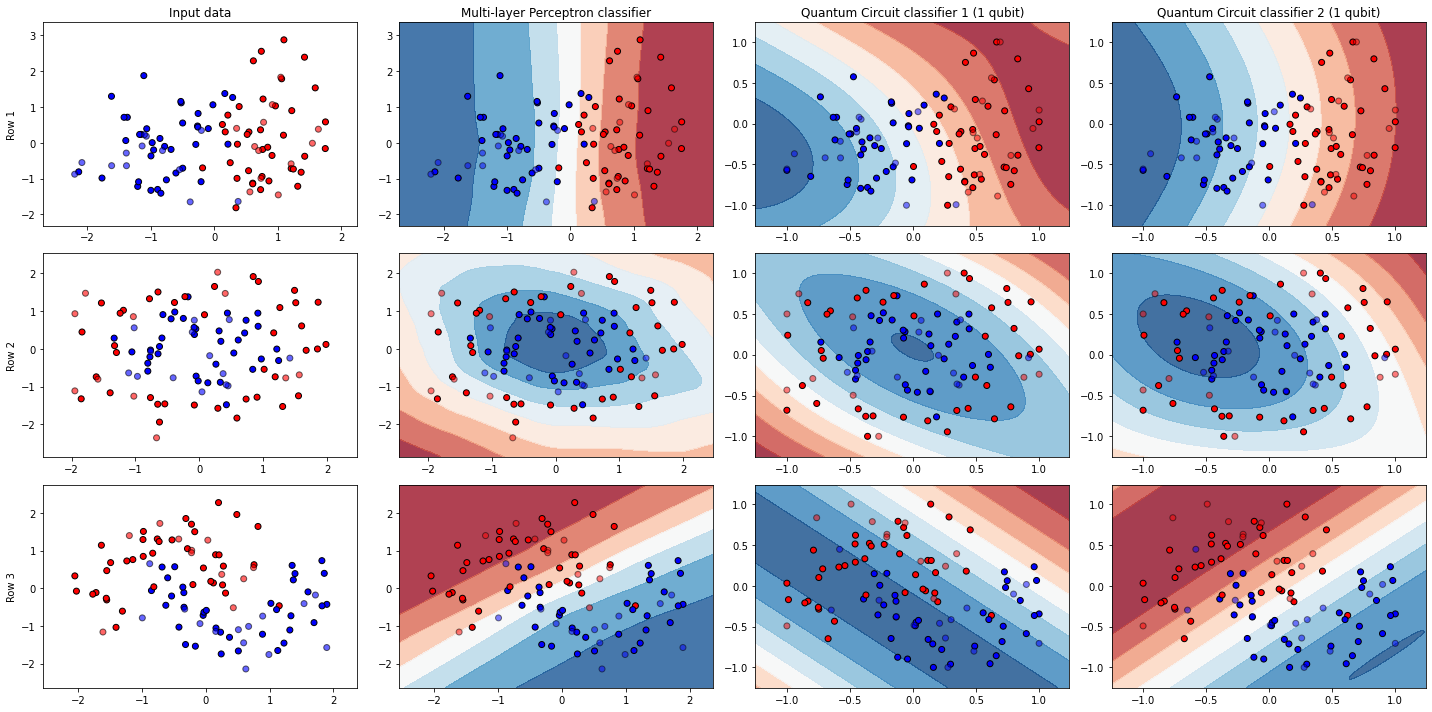

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6638519 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.5972042 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.4999581 | Acc train: 0.5466667 | Acc val: 0.5600000 | Acc all: 0.5400000 
Iter:     4 | Cost: 1.3886587 | Acc train: 0.5466667 | Acc val: 0.5600000 | Acc all: 0.5400000 
Iter:     5 | Cost: 1.2463230 | Acc train: 0.5733333 | Acc val: 0.6400000 | Acc all: 0.5700000 
Iter:     6 | Cost: 1.1058099 | Acc train: 0.5866667 | Acc val: 0.6400000 | Acc all: 0.5800000 
Iter:     7 | Cost: 0.9583844 | Acc train: 0.6266667 | Acc val: 0.7200000 | Acc all: 0.6300000 
Iter:     8 | Cost: 0.8240228 | Acc train: 0.6400000 | Acc val: 0.7600000 | Acc all: 0.6600000 
Iter:     9 | Cost: 0.7414265 | Acc train: 0.6800000 | Acc val: 0.8800000 | Acc all: 0.6900000 
Iter:    10 | Cost: 0.6964545 | Acc train: 0.7466667 | Acc val: 0.8400000 | Acc all: 0.7800000 
Iter:    11 | Cost: 0.6890739 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.3992115 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.3737116 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     3 | Cost: 1.3136707 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     4 | Cost: 1.2587238 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5300000 
Iter:     5 | Cost: 1.2008128 | Acc train: 0.5466667 | Acc val: 0.6000000 | Acc all: 0.5500000 
Iter:     6 | Cost: 1.1437741 | Acc train: 0.5600000 | Acc val: 0.6000000 | Acc all: 0.5700000 
Iter:     7 | Cost: 1.0805197 | Acc train: 0.5866667 | Acc val: 0.6000000 | Acc all: 0.5800000 
Iter:     8 | Cost: 1.0212192 | Acc train: 0.6000000 | Acc val: 0.6800000 | Acc all: 0.5800000 
Iter:     9 | Cost: 0.9771612 | Acc train: 0.6133333 | Acc val: 0.6800000 | Acc all: 0.6000000 
Iter:    10 | Cost: 0.9389273 | Acc train: 0.6400000 | Acc val: 0.6800000 | Acc all: 0.6400000 
Iter:    11 | Cost: 0.9019906 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6982079 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.6549539 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.5887564 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.4931303 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     5 | Cost: 1.3911998 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     6 | Cost: 1.2914673 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     7 | Cost: 1.2181430 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     8 | Cost: 1.1581418 | Acc train: 0.5200000 | Acc val: 0.6000000 | Acc all: 0.5300000 
Iter:     9 | Cost: 1.1141531 | Acc train: 0.5200000 | Acc val: 0.6000000 | Acc all: 0.5300000 
Iter:    10 | Cost: 1.0663402 | Acc train: 0.5466667 | Acc val: 0.5600000 | Acc all: 0.5300000 
Iter:    11 | Cost: 1.0336316 | Acc trai

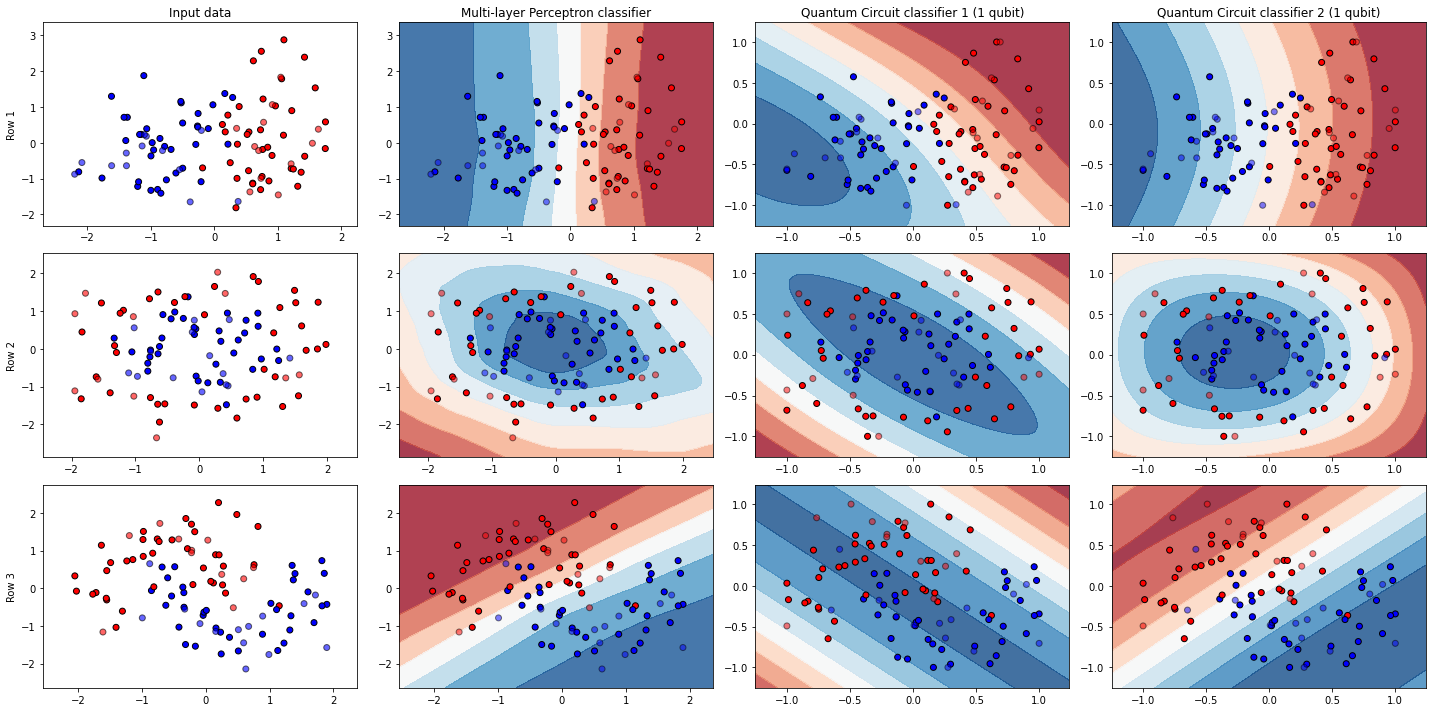

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6886147 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.6351508 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.5583958 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.4676093 | Acc train: 0.5333333 | Acc val: 0.5200000 | Acc all: 0.5200000 
Iter:     5 | Cost: 1.3802698 | Acc train: 0.5200000 | Acc val: 0.5200000 | Acc all: 0.5200000 
Iter:     6 | Cost: 1.2866161 | Acc train: 0.5466667 | Acc val: 0.6000000 | Acc all: 0.5400000 
Iter:     7 | Cost: 1.1828926 | Acc train: 0.5600000 | Acc val: 0.6000000 | Acc all: 0.5400000 
Iter:     8 | Cost: 1.0747934 | Acc train: 0.5733333 | Acc val: 0.6400000 | Acc all: 0.5600000 
Iter:     9 | Cost: 0.9785878 | Acc train: 0.6133333 | Acc val: 0.6400000 | Acc all: 0.6000000 
Iter:    10 | Cost: 0.8996054 | Acc train: 0.6000000 | Acc val: 0.6800000 | Acc all: 0.6200000 
Iter:    11 | Cost: 0.8439512 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.3907307 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.3670695 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     3 | Cost: 1.3298826 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     4 | Cost: 1.2816393 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     5 | Cost: 1.2133070 | Acc train: 0.5466667 | Acc val: 0.5600000 | Acc all: 0.5300000 
Iter:     6 | Cost: 1.1534604 | Acc train: 0.5600000 | Acc val: 0.6000000 | Acc all: 0.5700000 
Iter:     7 | Cost: 1.1046508 | Acc train: 0.5600000 | Acc val: 0.6400000 | Acc all: 0.5700000 
Iter:     8 | Cost: 1.0596839 | Acc train: 0.5733333 | Acc val: 0.6400000 | Acc all: 0.5800000 
Iter:     9 | Cost: 1.0162001 | Acc train: 0.6133333 | Acc val: 0.6400000 | Acc all: 0.6100000 
Iter:    10 | Cost: 0.9888283 | Acc train: 0.6266667 | Acc val: 0.6800000 | Acc all: 0.6200000 
Iter:    11 | Cost: 0.9694139 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6576067 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.5997847 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.5205860 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.4309463 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     5 | Cost: 1.3504854 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     6 | Cost: 1.2725464 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     7 | Cost: 1.1934188 | Acc train: 0.5200000 | Acc val: 0.6000000 | Acc all: 0.5200000 
Iter:     8 | Cost: 1.1373960 | Acc train: 0.5333333 | Acc val: 0.6000000 | Acc all: 0.5300000 
Iter:     9 | Cost: 1.0898223 | Acc train: 0.5600000 | Acc val: 0.6000000 | Acc all: 0.5400000 
Iter:    10 | Cost: 1.0644520 | Acc train: 0.5733333 | Acc val: 0.5600000 | Acc all: 0.5400000 
Iter:    11 | Cost: 1.0498223 | Acc trai

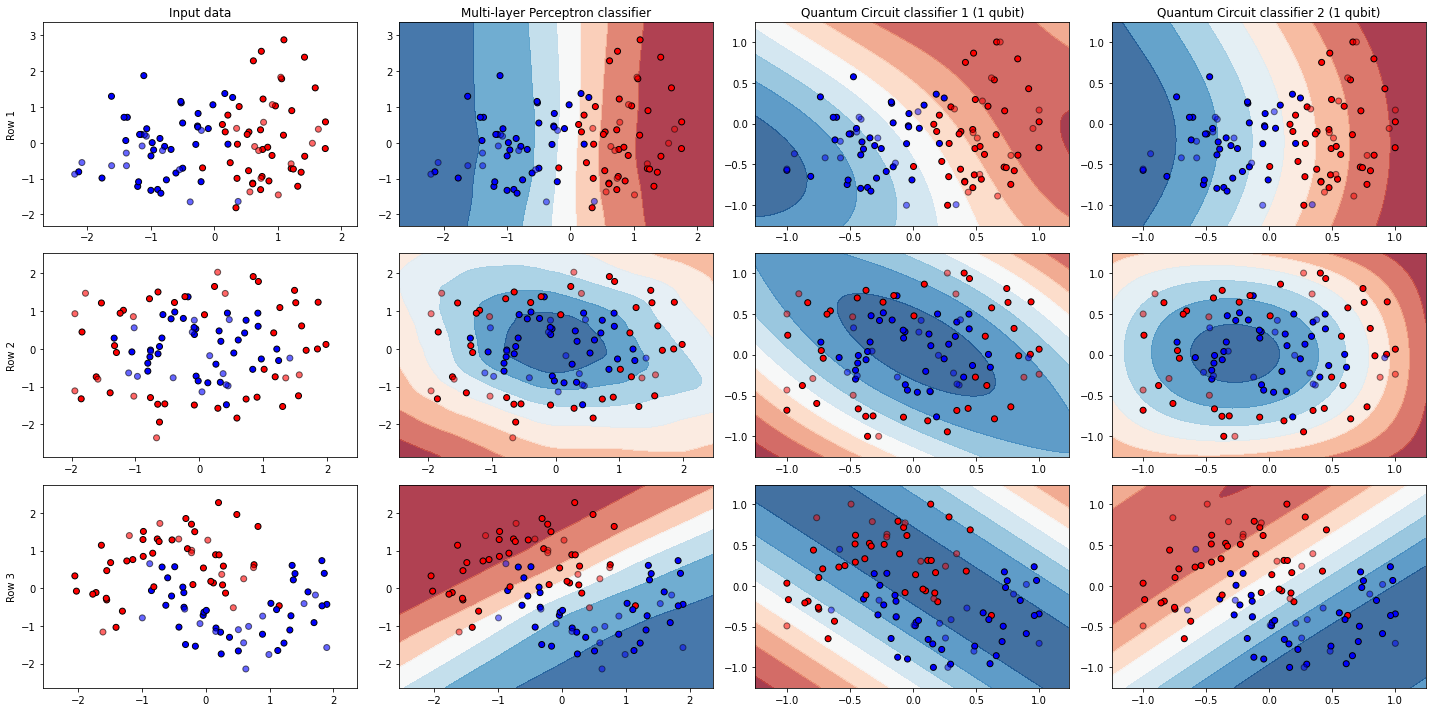

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6827610 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.6214580 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.5278311 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     4 | Cost: 1.4200483 | Acc train: 0.5466667 | Acc val: 0.5600000 | Acc all: 0.5400000 
Iter:     5 | Cost: 1.3290246 | Acc train: 0.5733333 | Acc val: 0.6400000 | Acc all: 0.5700000 
Iter:     6 | Cost: 1.2184224 | Acc train: 0.5733333 | Acc val: 0.6400000 | Acc all: 0.5700000 
Iter:     7 | Cost: 1.1043062 | Acc train: 0.5866667 | Acc val: 0.6400000 | Acc all: 0.5800000 
Iter:     8 | Cost: 0.9776154 | Acc train: 0.6266667 | Acc val: 0.7200000 | Acc all: 0.6300000 
Iter:     9 | Cost: 0.8502217 | Acc train: 0.6133333 | Acc val: 0.7200000 | Acc all: 0.6300000 
Iter:    10 | Cost: 0.7531735 | Acc train: 0.6666667 | Acc val: 0.8400000 | Acc all: 0.6800000 
Iter:    11 | Cost: 0.6963996 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.3867379 | Acc train: 0.5066667 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.3415231 | Acc train: 0.5066667 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.2653253 | Acc train: 0.5066667 | Acc val: 0.6000000 | Acc all: 0.5300000 
Iter:     4 | Cost: 1.1935807 | Acc train: 0.5466667 | Acc val: 0.6000000 | Acc all: 0.5400000 
Iter:     5 | Cost: 1.1128756 | Acc train: 0.5600000 | Acc val: 0.6400000 | Acc all: 0.5600000 
Iter:     6 | Cost: 1.0374771 | Acc train: 0.6000000 | Acc val: 0.6800000 | Acc all: 0.6000000 
Iter:     7 | Cost: 0.9738871 | Acc train: 0.6000000 | Acc val: 0.7200000 | Acc all: 0.6200000 
Iter:     8 | Cost: 0.9300955 | Acc train: 0.6400000 | Acc val: 0.7200000 | Acc all: 0.6400000 
Iter:     9 | Cost: 0.8985928 | Acc train: 0.6666667 | Acc val: 0.6800000 | Acc all: 0.6400000 
Iter:    10 | Cost: 0.8744024 | Acc train: 0.6933333 | Acc val: 0.6400000 | Acc all: 0.6700000 
Iter:    11 | Cost: 0.8575631 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6959878 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.6376215 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.5671524 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.5015895 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     5 | Cost: 1.4010523 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     6 | Cost: 1.3038725 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     7 | Cost: 1.2054739 | Acc train: 0.5200000 | Acc val: 0.6000000 | Acc all: 0.5200000 
Iter:     8 | Cost: 1.1248305 | Acc train: 0.5200000 | Acc val: 0.6000000 | Acc all: 0.5300000 
Iter:     9 | Cost: 1.0598331 | Acc train: 0.5466667 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:    10 | Cost: 1.0189878 | Acc train: 0.5466667 | Acc val: 0.5200000 | Acc all: 0.5300000 
Iter:    11 | Cost: 0.9985760 | Acc trai

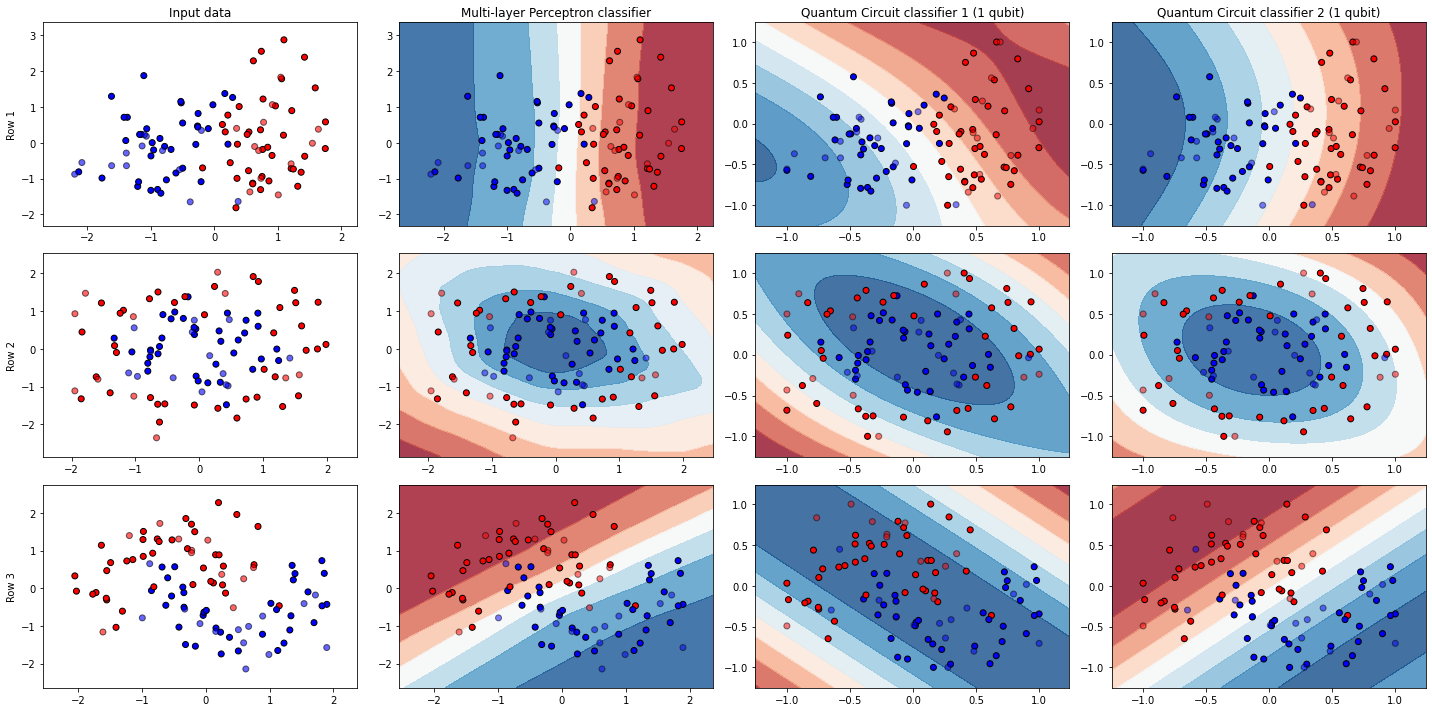

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6869140 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.6016764 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.5182117 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.4119157 | Acc train: 0.5333333 | Acc val: 0.5200000 | Acc all: 0.5200000 
Iter:     5 | Cost: 1.3011578 | Acc train: 0.5600000 | Acc val: 0.6000000 | Acc all: 0.5500000 
Iter:     6 | Cost: 1.1848110 | Acc train: 0.5733333 | Acc val: 0.6000000 | Acc all: 0.5600000 
Iter:     7 | Cost: 1.0878959 | Acc train: 0.5733333 | Acc val: 0.6400000 | Acc all: 0.5600000 
Iter:     8 | Cost: 0.9937174 | Acc train: 0.6133333 | Acc val: 0.6800000 | Acc all: 0.6100000 
Iter:     9 | Cost: 0.9100690 | Acc train: 0.6266667 | Acc val: 0.6800000 | Acc all: 0.6300000 
Iter:    10 | Cost: 0.8261787 | Acc train: 0.6400000 | Acc val: 0.7200000 | Acc all: 0.6500000 
Iter:    11 | Cost: 0.7664044 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.3816904 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.3144485 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     3 | Cost: 1.2504548 | Acc train: 0.5200000 | Acc val: 0.6000000 | Acc all: 0.5400000 
Iter:     4 | Cost: 1.1868399 | Acc train: 0.5466667 | Acc val: 0.6000000 | Acc all: 0.5500000 
Iter:     5 | Cost: 1.1229005 | Acc train: 0.5600000 | Acc val: 0.6400000 | Acc all: 0.5500000 
Iter:     6 | Cost: 1.0507322 | Acc train: 0.5866667 | Acc val: 0.6400000 | Acc all: 0.5700000 
Iter:     7 | Cost: 0.9927049 | Acc train: 0.6400000 | Acc val: 0.6800000 | Acc all: 0.6200000 
Iter:     8 | Cost: 0.9356312 | Acc train: 0.6400000 | Acc val: 0.7200000 | Acc all: 0.6300000 
Iter:     9 | Cost: 0.8962326 | Acc train: 0.6533333 | Acc val: 0.7600000 | Acc all: 0.6600000 
Iter:    10 | Cost: 0.8681572 | Acc train: 0.6800000 | Acc val: 0.7200000 | Acc all: 0.6500000 
Iter:    11 | Cost: 0.8504779 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6883003 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.6142078 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.5291654 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.4285971 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     5 | Cost: 1.3220639 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     6 | Cost: 1.2341667 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     7 | Cost: 1.1553491 | Acc train: 0.5200000 | Acc val: 0.6000000 | Acc all: 0.5300000 
Iter:     8 | Cost: 1.0866149 | Acc train: 0.5866667 | Acc val: 0.5600000 | Acc all: 0.5800000 
Iter:     9 | Cost: 1.0390231 | Acc train: 0.5466667 | Acc val: 0.5600000 | Acc all: 0.5700000 
Iter:    10 | Cost: 1.0125857 | Acc train: 0.5066667 | Acc val: 0.4800000 | Acc all: 0.5100000 
Iter:    11 | Cost: 1.0031212 | Acc trai

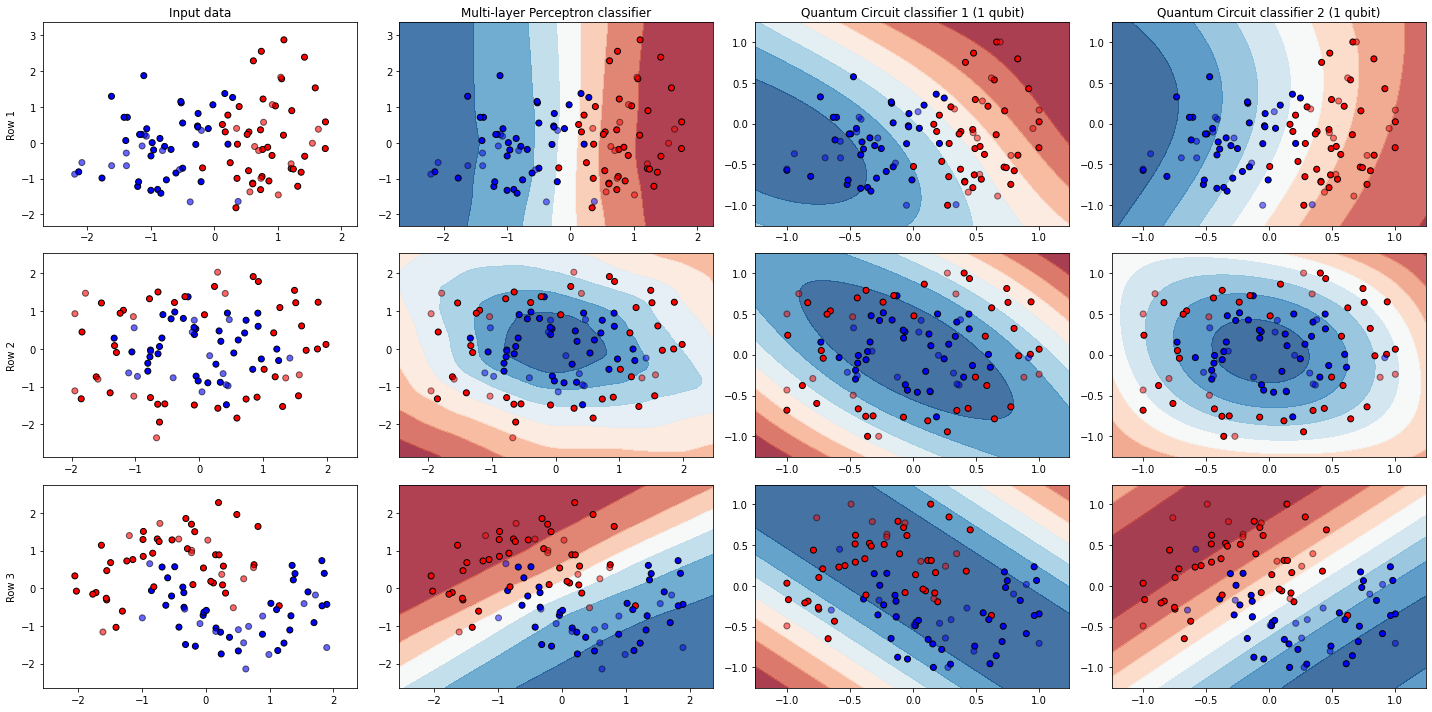

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.7020672 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     2 | Cost: 1.6389732 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     3 | Cost: 1.5452263 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     4 | Cost: 1.4477920 | Acc train: 0.5466667 | Acc val: 0.5600000 | Acc all: 0.5300000 
Iter:     5 | Cost: 1.3379461 | Acc train: 0.5333333 | Acc val: 0.5200000 | Acc all: 0.5500000 
Iter:     6 | Cost: 1.2352469 | Acc train: 0.5600000 | Acc val: 0.6000000 | Acc all: 0.5500000 
Iter:     7 | Cost: 1.1535976 | Acc train: 0.5733333 | Acc val: 0.6000000 | Acc all: 0.5600000 
Iter:     8 | Cost: 1.0670924 | Acc train: 0.5866667 | Acc val: 0.6400000 | Acc all: 0.5800000 
Iter:     9 | Cost: 0.9870520 | Acc train: 0.6133333 | Acc val: 0.6800000 | Acc all: 0.6100000 
Iter:    10 | Cost: 0.9057355 | Acc train: 0.6266667 | Acc val: 0.6800000 | Acc all: 0.6300000 
Iter:    11 | Cost: 0.8409739 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.3916955 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     2 | Cost: 1.3259362 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     3 | Cost: 1.2425079 | Acc train: 0.5600000 | Acc val: 0.5600000 | Acc all: 0.5300000 
Iter:     4 | Cost: 1.1637854 | Acc train: 0.5600000 | Acc val: 0.5600000 | Acc all: 0.5600000 
Iter:     5 | Cost: 1.0826111 | Acc train: 0.5600000 | Acc val: 0.6400000 | Acc all: 0.5700000 
Iter:     6 | Cost: 1.0204769 | Acc train: 0.6000000 | Acc val: 0.6400000 | Acc all: 0.6000000 
Iter:     7 | Cost: 0.9757838 | Acc train: 0.6133333 | Acc val: 0.6800000 | Acc all: 0.6200000 
Iter:     8 | Cost: 0.9427355 | Acc train: 0.6400000 | Acc val: 0.7200000 | Acc all: 0.6200000 
Iter:     9 | Cost: 0.9122623 | Acc train: 0.6400000 | Acc val: 0.7200000 | Acc all: 0.6400000 
Iter:    10 | Cost: 0.8881565 | Acc train: 0.6666667 | Acc val: 0.7200000 | Acc all: 0.6600000 
Iter:    11 | Cost: 0.8728210 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6969756 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.6574188 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.5863771 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.5016028 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     5 | Cost: 1.4204276 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     6 | Cost: 1.3569238 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     7 | Cost: 1.2939903 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     8 | Cost: 1.2314684 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     9 | Cost: 1.1735033 | Acc train: 0.5200000 | Acc val: 0.6000000 | Acc all: 0.5200000 
Iter:    10 | Cost: 1.1186314 | Acc train: 0.5200000 | Acc val: 0.6000000 | Acc all: 0.5300000 
Iter:    11 | Cost: 1.0758966 | Acc trai

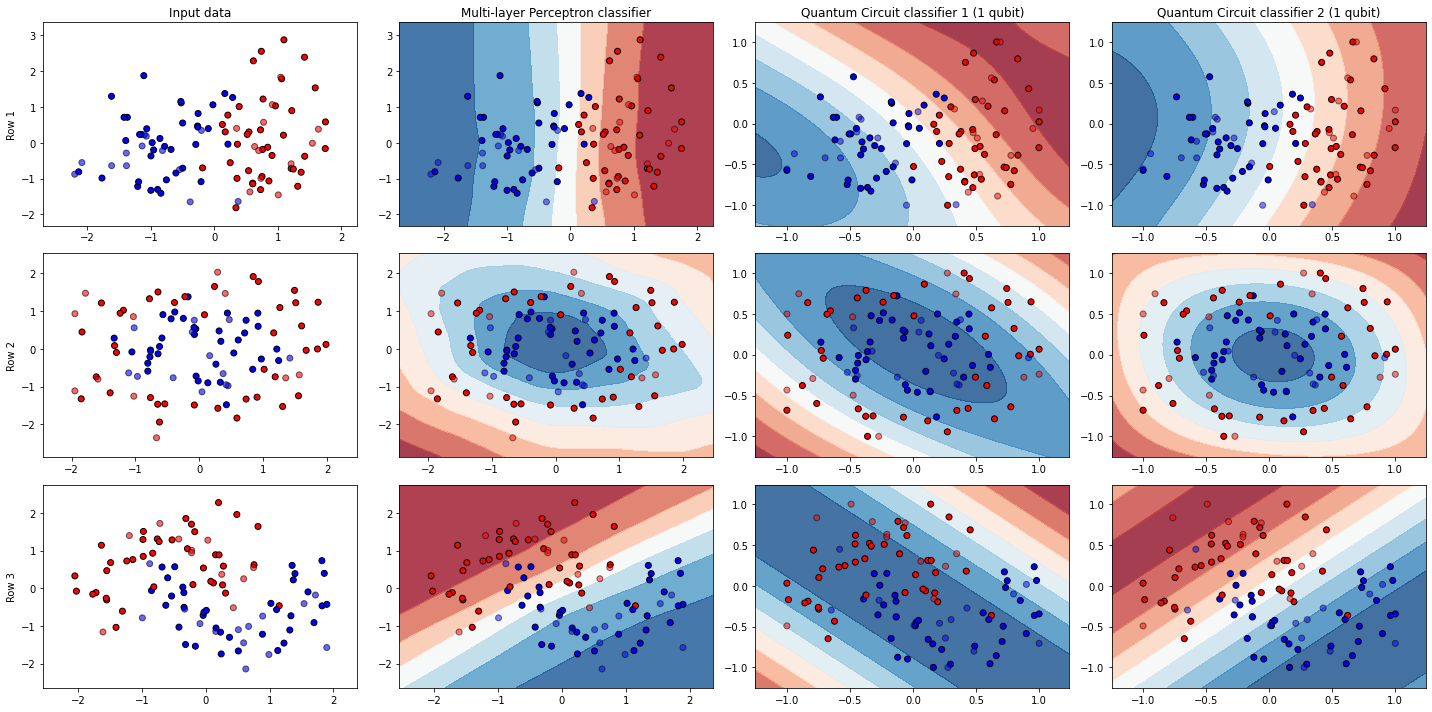

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.7137533 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.6590483 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.5875874 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     4 | Cost: 1.4986884 | Acc train: 0.5466667 | Acc val: 0.5600000 | Acc all: 0.5300000 
Iter:     5 | Cost: 1.3990738 | Acc train: 0.5466667 | Acc val: 0.5600000 | Acc all: 0.5300000 
Iter:     6 | Cost: 1.2897457 | Acc train: 0.5733333 | Acc val: 0.6400000 | Acc all: 0.5700000 
Iter:     7 | Cost: 1.1849242 | Acc train: 0.5866667 | Acc val: 0.6400000 | Acc all: 0.5800000 
Iter:     8 | Cost: 1.0847749 | Acc train: 0.6000000 | Acc val: 0.6800000 | Acc all: 0.5900000 
Iter:     9 | Cost: 0.9812338 | Acc train: 0.6266667 | Acc val: 0.7200000 | Acc all: 0.6300000 
Iter:    10 | Cost: 0.8973381 | Acc train: 0.6400000 | Acc val: 0.7200000 | Acc all: 0.6500000 
Iter:    11 | Cost: 0.8294537 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.4003845 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     2 | Cost: 1.3736396 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     3 | Cost: 1.3178933 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     4 | Cost: 1.2582399 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     5 | Cost: 1.1884207 | Acc train: 0.5600000 | Acc val: 0.5600000 | Acc all: 0.5600000 
Iter:     6 | Cost: 1.1248927 | Acc train: 0.5600000 | Acc val: 0.6400000 | Acc all: 0.5700000 
Iter:     7 | Cost: 1.0737693 | Acc train: 0.5733333 | Acc val: 0.6400000 | Acc all: 0.5800000 
Iter:     8 | Cost: 1.0289517 | Acc train: 0.5866667 | Acc val: 0.6400000 | Acc all: 0.6100000 
Iter:     9 | Cost: 0.9961060 | Acc train: 0.6000000 | Acc val: 0.6800000 | Acc all: 0.6100000 
Iter:    10 | Cost: 0.9738016 | Acc train: 0.6000000 | Acc val: 0.6800000 | Acc all: 0.6200000 
Iter:    11 | Cost: 0.9423568 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.7056076 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.6999264 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.6464548 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.5934965 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     5 | Cost: 1.5340070 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     6 | Cost: 1.4781062 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     7 | Cost: 1.3974874 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     8 | Cost: 1.3102959 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     9 | Cost: 1.2180127 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:    10 | Cost: 1.1600244 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5300000 
Iter:    11 | Cost: 1.0987406 | Acc trai

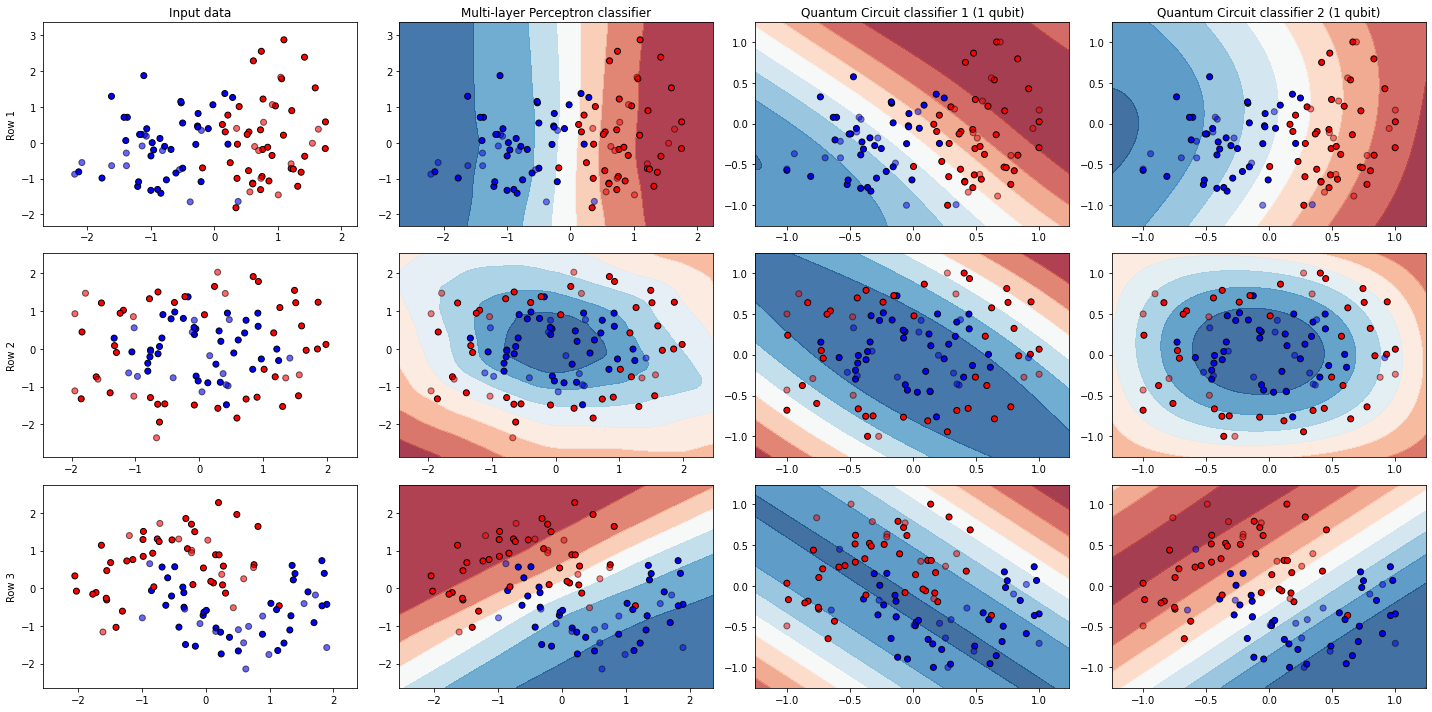

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6854829 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.6278371 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.5475164 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     4 | Cost: 1.4408772 | Acc train: 0.5466667 | Acc val: 0.5600000 | Acc all: 0.5300000 
Iter:     5 | Cost: 1.3164973 | Acc train: 0.5733333 | Acc val: 0.6400000 | Acc all: 0.5700000 
Iter:     6 | Cost: 1.2070199 | Acc train: 0.5733333 | Acc val: 0.6400000 | Acc all: 0.5700000 
Iter:     7 | Cost: 1.0954863 | Acc train: 0.5866667 | Acc val: 0.6400000 | Acc all: 0.5800000 
Iter:     8 | Cost: 0.9999015 | Acc train: 0.6266667 | Acc val: 0.7200000 | Acc all: 0.6300000 
Iter:     9 | Cost: 0.9136292 | Acc train: 0.6400000 | Acc val: 0.7200000 | Acc all: 0.6500000 
Iter:    10 | Cost: 0.8377702 | Acc train: 0.6266667 | Acc val: 0.7200000 | Acc all: 0.6600000 
Iter:    11 | Cost: 0.7825786 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.3915959 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.3394291 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     3 | Cost: 1.2674951 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     4 | Cost: 1.1917314 | Acc train: 0.5600000 | Acc val: 0.6000000 | Acc all: 0.5500000 
Iter:     5 | Cost: 1.1289736 | Acc train: 0.5866667 | Acc val: 0.6000000 | Acc all: 0.5700000 
Iter:     6 | Cost: 1.0701781 | Acc train: 0.5866667 | Acc val: 0.6000000 | Acc all: 0.5800000 
Iter:     7 | Cost: 1.0189235 | Acc train: 0.6000000 | Acc val: 0.6800000 | Acc all: 0.5800000 
Iter:     8 | Cost: 0.9730430 | Acc train: 0.6133333 | Acc val: 0.6800000 | Acc all: 0.5900000 
Iter:     9 | Cost: 0.9282045 | Acc train: 0.6400000 | Acc val: 0.6800000 | Acc all: 0.6500000 
Iter:    10 | Cost: 0.8939839 | Acc train: 0.6800000 | Acc val: 0.7600000 | Acc all: 0.6600000 
Iter:    11 | Cost: 0.8731208 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6855079 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.6471508 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.5927430 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.5434552 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     5 | Cost: 1.4876556 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     6 | Cost: 1.4296018 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     7 | Cost: 1.3623750 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     8 | Cost: 1.2975619 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5200000 
Iter:     9 | Cost: 1.2490954 | Acc train: 0.5066667 | Acc val: 0.6000000 | Acc all: 0.5200000 
Iter:    10 | Cost: 1.2055579 | Acc train: 0.5466667 | Acc val: 0.6000000 | Acc all: 0.5300000 
Iter:    11 | Cost: 1.1600194 | Acc trai

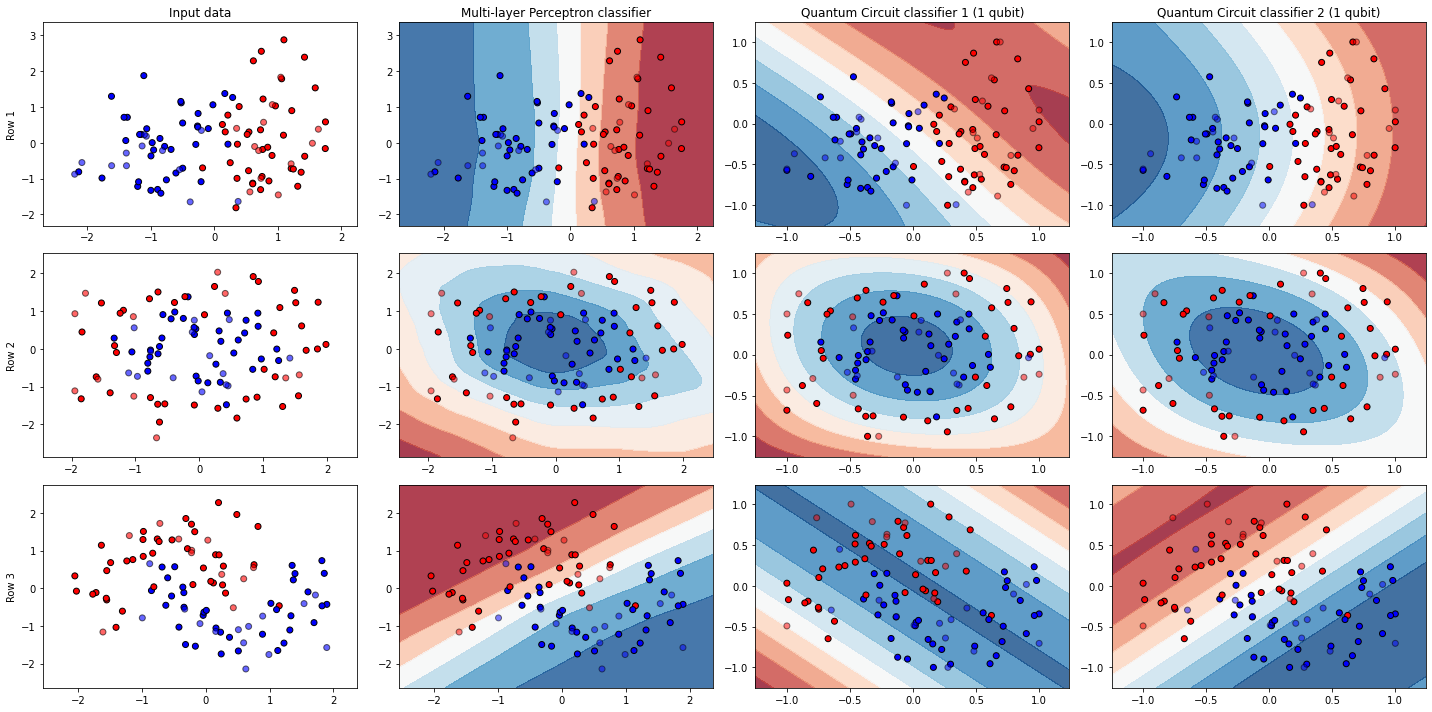

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6991259 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.6441605 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.5875088 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     4 | Cost: 1.5022827 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5300000 
Iter:     5 | Cost: 1.4141742 | Acc train: 0.5333333 | Acc val: 0.5600000 | Acc all: 0.5300000 
Iter:     6 | Cost: 1.3251898 | Acc train: 0.5466667 | Acc val: 0.5600000 | Acc all: 0.5600000 
Iter:     7 | Cost: 1.2239834 | Acc train: 0.5600000 | Acc val: 0.6000000 | Acc all: 0.5600000 
Iter:     8 | Cost: 1.1001850 | Acc train: 0.5733333 | Acc val: 0.6000000 | Acc all: 0.5700000 
Iter:     9 | Cost: 0.9721646 | Acc train: 0.6133333 | Acc val: 0.7200000 | Acc all: 0.6200000 
Iter:    10 | Cost: 0.8641261 | Acc train: 0.6133333 | Acc val: 0.7200000 | Acc all: 0.6200000 
Iter:    11 | Cost: 0.7808695 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.3829217 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     2 | Cost: 1.3417835 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     3 | Cost: 1.2879459 | Acc train: 0.5333333 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     4 | Cost: 1.2126401 | Acc train: 0.5600000 | Acc val: 0.5600000 | Acc all: 0.5500000 
Iter:     5 | Cost: 1.1486013 | Acc train: 0.5733333 | Acc val: 0.6000000 | Acc all: 0.5600000 
Iter:     6 | Cost: 1.0840270 | Acc train: 0.5866667 | Acc val: 0.6000000 | Acc all: 0.5900000 
Iter:     7 | Cost: 1.0233255 | Acc train: 0.6000000 | Acc val: 0.6400000 | Acc all: 0.6100000 
Iter:     8 | Cost: 0.9793833 | Acc train: 0.6133333 | Acc val: 0.6800000 | Acc all: 0.6300000 
Iter:     9 | Cost: 0.9396932 | Acc train: 0.6266667 | Acc val: 0.6400000 | Acc all: 0.6500000 
Iter:    10 | Cost: 0.9055941 | Acc train: 0.6400000 | Acc val: 0.6400000 | Acc all: 0.6300000 
Iter:    11 | Cost: 0.8843289 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6843120 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.6249456 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.5214762 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.4080262 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     5 | Cost: 1.3197615 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     6 | Cost: 1.2439761 | Acc train: 0.5066667 | Acc val: 0.6000000 | Acc all: 0.5200000 
Iter:     7 | Cost: 1.1725325 | Acc train: 0.5466667 | Acc val: 0.6000000 | Acc all: 0.5200000 
Iter:     8 | Cost: 1.1171652 | Acc train: 0.5466667 | Acc val: 0.5600000 | Acc all: 0.5700000 
Iter:     9 | Cost: 1.0769317 | Acc train: 0.5600000 | Acc val: 0.5600000 | Acc all: 0.5700000 
Iter:    10 | Cost: 1.0519560 | Acc train: 0.5600000 | Acc val: 0.5200000 | Acc all: 0.5400000 
Iter:    11 | Cost: 1.0385786 | Acc trai

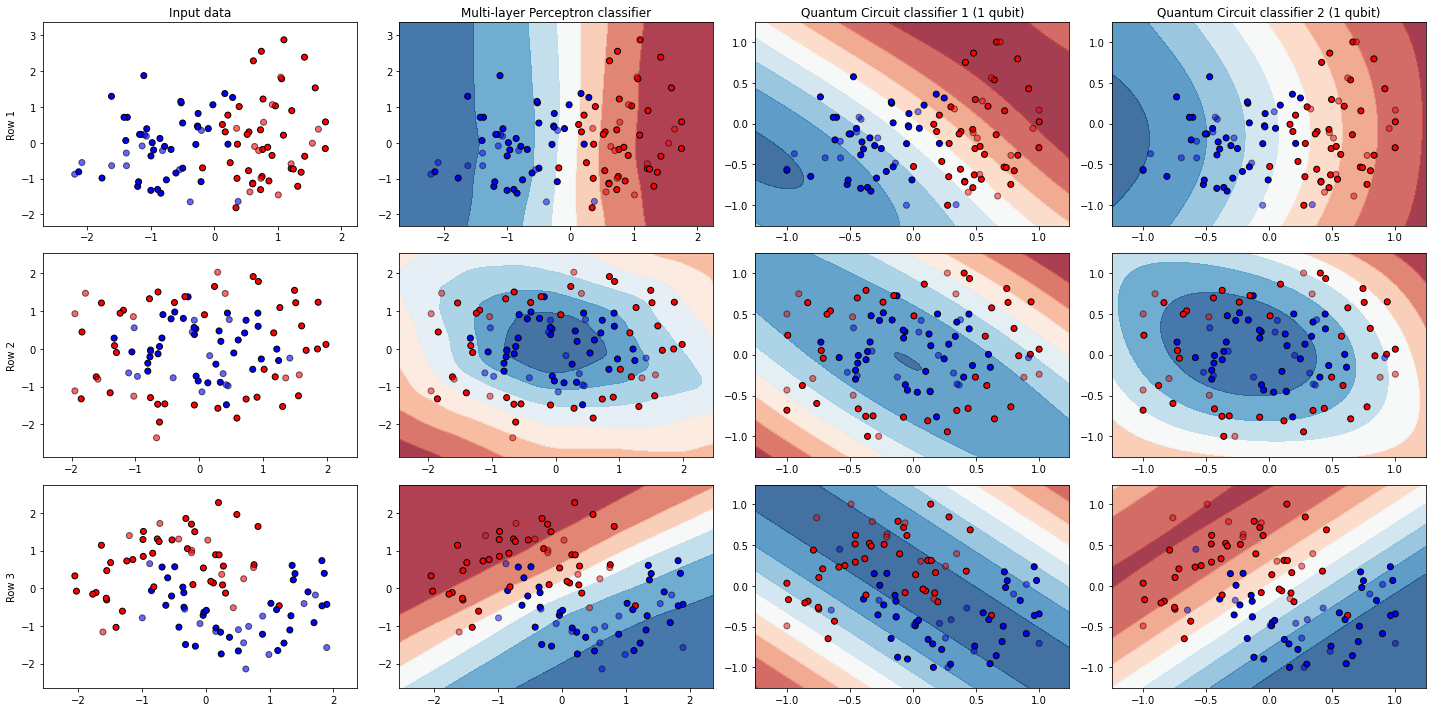

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6748360 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.6177590 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.5257921 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     4 | Cost: 1.4082785 | Acc train: 0.5466667 | Acc val: 0.5600000 | Acc all: 0.5300000 
Iter:     5 | Cost: 1.2795994 | Acc train: 0.5733333 | Acc val: 0.6400000 | Acc all: 0.5700000 
Iter:     6 | Cost: 1.1671177 | Acc train: 0.5866667 | Acc val: 0.6400000 | Acc all: 0.5800000 
Iter:     7 | Cost: 1.0766983 | Acc train: 0.6000000 | Acc val: 0.6800000 | Acc all: 0.6000000 
Iter:     8 | Cost: 0.9856407 | Acc train: 0.6266667 | Acc val: 0.7200000 | Acc all: 0.6300000 
Iter:     9 | Cost: 0.9014892 | Acc train: 0.6400000 | Acc val: 0.7200000 | Acc all: 0.6500000 
Iter:    10 | Cost: 0.8209931 | Acc train: 0.6400000 | Acc val: 0.7600000 | Acc all: 0.6600000 
Iter:    11 | Cost: 0.7573568 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.4152860 | Acc train: 0.5066667 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.3948412 | Acc train: 0.5066667 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.3594659 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     4 | Cost: 1.2809892 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     5 | Cost: 1.2024352 | Acc train: 0.5600000 | Acc val: 0.5600000 | Acc all: 0.5400000 
Iter:     6 | Cost: 1.1245582 | Acc train: 0.5600000 | Acc val: 0.6400000 | Acc all: 0.5700000 
Iter:     7 | Cost: 1.0511247 | Acc train: 0.5733333 | Acc val: 0.6400000 | Acc all: 0.5900000 
Iter:     8 | Cost: 0.9821657 | Acc train: 0.6266667 | Acc val: 0.6800000 | Acc all: 0.6200000 
Iter:     9 | Cost: 0.9294736 | Acc train: 0.6400000 | Acc val: 0.6800000 | Acc all: 0.6500000 
Iter:    10 | Cost: 0.8978423 | Acc train: 0.6800000 | Acc val: 0.6400000 | Acc all: 0.6400000 
Iter:    11 | Cost: 0.8799685 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6903349 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.6672831 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.6279660 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.5660650 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     5 | Cost: 1.4683352 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     6 | Cost: 1.3673308 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     7 | Cost: 1.2900347 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     8 | Cost: 1.2079992 | Acc train: 0.5066667 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     9 | Cost: 1.1437746 | Acc train: 0.5466667 | Acc val: 0.6000000 | Acc all: 0.5200000 
Iter:    10 | Cost: 1.0855283 | Acc train: 0.5866667 | Acc val: 0.5600000 | Acc all: 0.5900000 
Iter:    11 | Cost: 1.0412393 | Acc trai

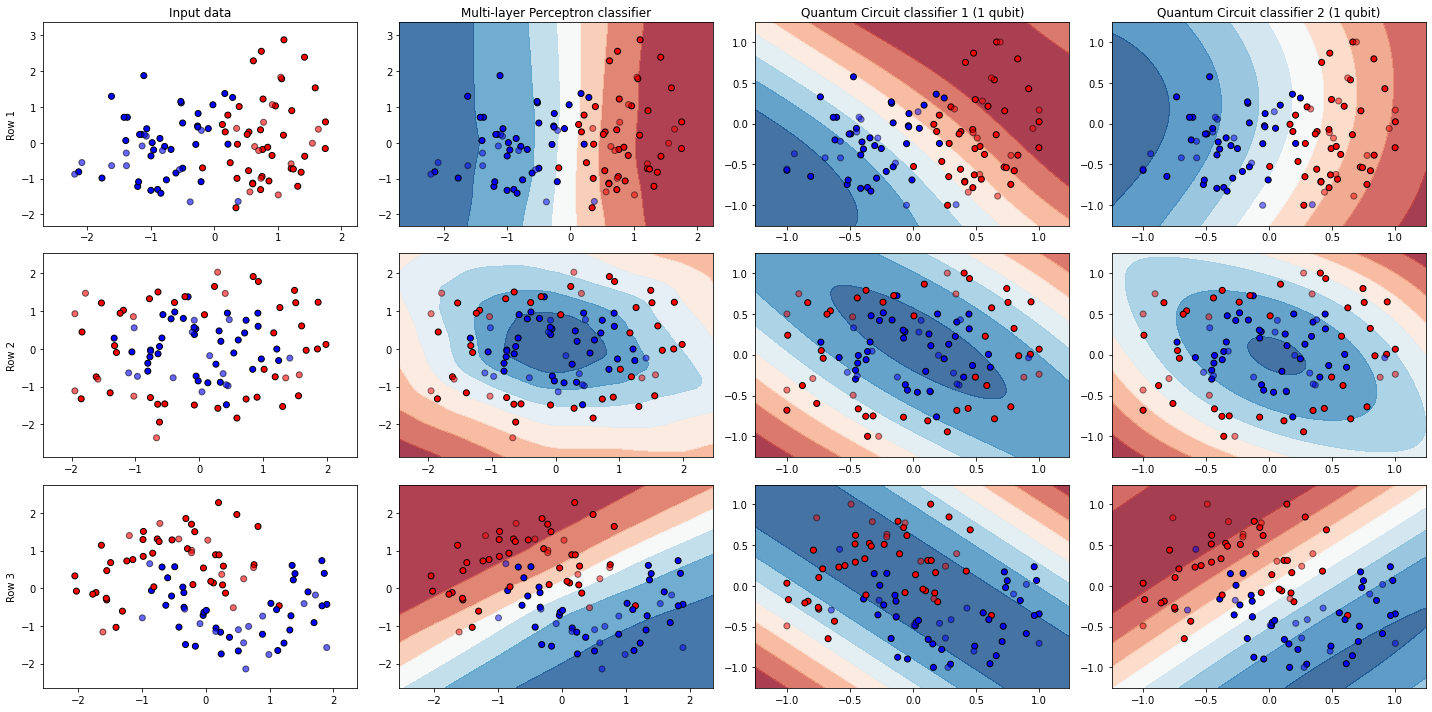

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6785857 | Acc train: 0.5066667 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.6035909 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.5268156 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.4461885 | Acc train: 0.5200000 | Acc val: 0.5200000 | Acc all: 0.5200000 
Iter:     5 | Cost: 1.3551182 | Acc train: 0.5200000 | Acc val: 0.5200000 | Acc all: 0.5100000 
Iter:     6 | Cost: 1.2601528 | Acc train: 0.5466667 | Acc val: 0.6000000 | Acc all: 0.5500000 
Iter:     7 | Cost: 1.1547818 | Acc train: 0.5600000 | Acc val: 0.6000000 | Acc all: 0.5600000 
Iter:     8 | Cost: 1.0569926 | Acc train: 0.5733333 | Acc val: 0.6400000 | Acc all: 0.5800000 
Iter:     9 | Cost: 0.9538139 | Acc train: 0.6133333 | Acc val: 0.6800000 | Acc all: 0.6200000 
Iter:    10 | Cost: 0.8637010 | Acc train: 0.6133333 | Acc val: 0.6800000 | Acc all: 0.6400000 
Iter:    11 | Cost: 0.7959838 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.4043795 | Acc train: 0.5066667 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.3604926 | Acc train: 0.5066667 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.3223438 | Acc train: 0.5066667 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     4 | Cost: 1.2840409 | Acc train: 0.5200000 | Acc val: 0.6000000 | Acc all: 0.5300000 
Iter:     5 | Cost: 1.2484963 | Acc train: 0.5200000 | Acc val: 0.6000000 | Acc all: 0.5400000 
Iter:     6 | Cost: 1.2103288 | Acc train: 0.5466667 | Acc val: 0.6000000 | Acc all: 0.5500000 
Iter:     7 | Cost: 1.1560745 | Acc train: 0.5466667 | Acc val: 0.6000000 | Acc all: 0.5500000 
Iter:     8 | Cost: 1.0932637 | Acc train: 0.5600000 | Acc val: 0.6400000 | Acc all: 0.5500000 
Iter:     9 | Cost: 1.0268744 | Acc train: 0.6133333 | Acc val: 0.6400000 | Acc all: 0.5900000 
Iter:    10 | Cost: 0.9733029 | Acc train: 0.6400000 | Acc val: 0.6800000 | Acc all: 0.6100000 
Iter:    11 | Cost: 0.9355804 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6600917 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.6181671 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.5663321 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.5052619 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     5 | Cost: 1.4391185 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     6 | Cost: 1.3941884 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     7 | Cost: 1.3267241 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     8 | Cost: 1.2552571 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     9 | Cost: 1.1932080 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:    10 | Cost: 1.1430821 | Acc train: 0.5333333 | Acc val: 0.6000000 | Acc all: 0.5300000 
Iter:    11 | Cost: 1.0881031 | Acc trai

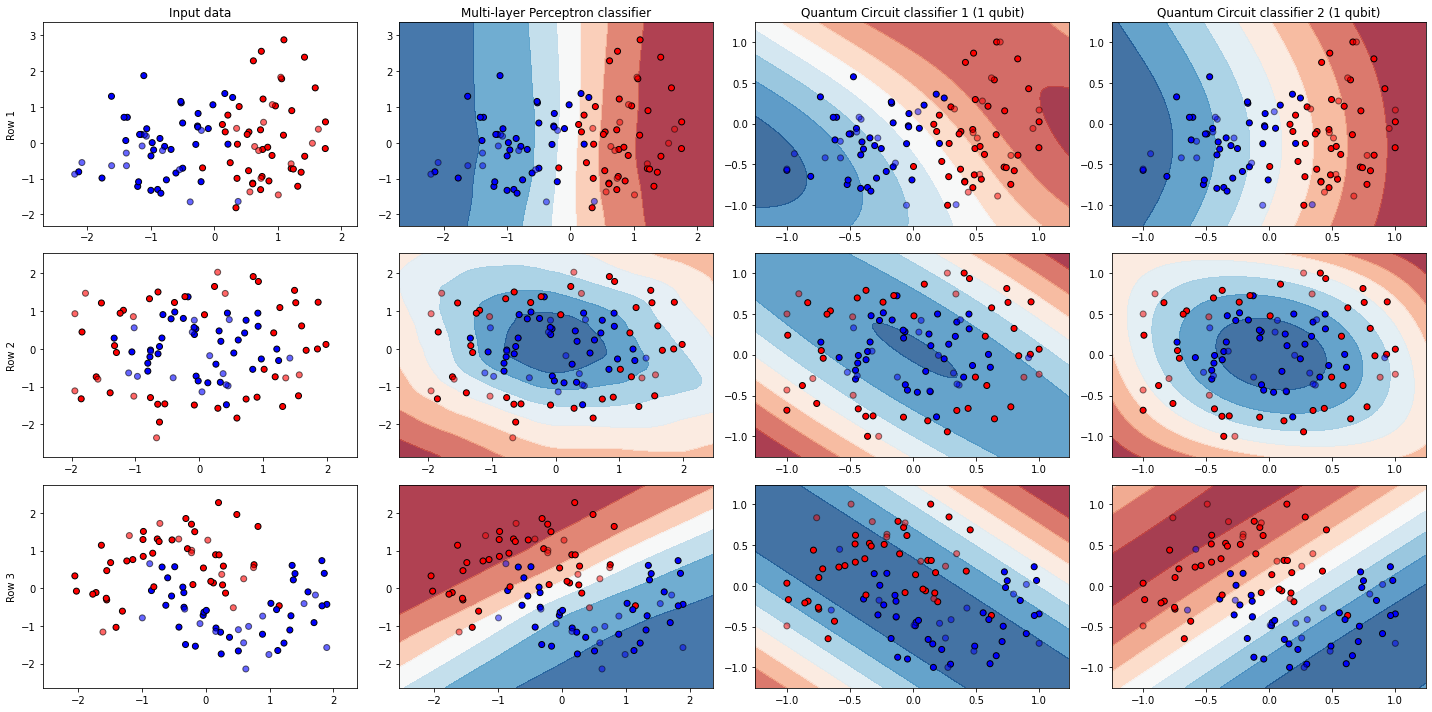

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.7132146 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.6897531 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     3 | Cost: 1.6126391 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     4 | Cost: 1.5220068 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5300000 
Iter:     5 | Cost: 1.3955498 | Acc train: 0.5466667 | Acc val: 0.5600000 | Acc all: 0.5400000 
Iter:     6 | Cost: 1.2722355 | Acc train: 0.5733333 | Acc val: 0.6400000 | Acc all: 0.5700000 
Iter:     7 | Cost: 1.1648020 | Acc train: 0.5866667 | Acc val: 0.6400000 | Acc all: 0.5800000 
Iter:     8 | Cost: 1.0667331 | Acc train: 0.6000000 | Acc val: 0.6800000 | Acc all: 0.6000000 
Iter:     9 | Cost: 0.9819547 | Acc train: 0.6266667 | Acc val: 0.7200000 | Acc all: 0.6300000 
Iter:    10 | Cost: 0.8941535 | Acc train: 0.6400000 | Acc val: 0.7200000 | Acc all: 0.6500000 
Iter:    11 | Cost: 0.8081268 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.4190354 | Acc train: 0.5066667 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.3762769 | Acc train: 0.5066667 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.3063488 | Acc train: 0.5066667 | Acc val: 0.6000000 | Acc all: 0.5200000 
Iter:     4 | Cost: 1.2439011 | Acc train: 0.5333333 | Acc val: 0.6000000 | Acc all: 0.5400000 
Iter:     5 | Cost: 1.1688974 | Acc train: 0.5600000 | Acc val: 0.6400000 | Acc all: 0.5400000 
Iter:     6 | Cost: 1.0928191 | Acc train: 0.5733333 | Acc val: 0.6400000 | Acc all: 0.5700000 
Iter:     7 | Cost: 1.0226159 | Acc train: 0.6000000 | Acc val: 0.6800000 | Acc all: 0.6000000 
Iter:     8 | Cost: 0.9665676 | Acc train: 0.6000000 | Acc val: 0.7200000 | Acc all: 0.6200000 
Iter:     9 | Cost: 0.9283047 | Acc train: 0.6400000 | Acc val: 0.7200000 | Acc all: 0.6600000 
Iter:    10 | Cost: 0.8964809 | Acc train: 0.6533333 | Acc val: 0.7200000 | Acc all: 0.6500000 
Iter:    11 | Cost: 0.8705925 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6710953 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.6303974 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.5691183 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.4881899 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     5 | Cost: 1.3970130 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     6 | Cost: 1.3158791 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.4900000 
Iter:     7 | Cost: 1.2392252 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     8 | Cost: 1.1682768 | Acc train: 0.5200000 | Acc val: 0.6000000 | Acc all: 0.5200000 
Iter:     9 | Cost: 1.1116922 | Acc train: 0.5200000 | Acc val: 0.6000000 | Acc all: 0.5300000 
Iter:    10 | Cost: 1.0570429 | Acc train: 0.5733333 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:    11 | Cost: 1.0178459 | Acc trai

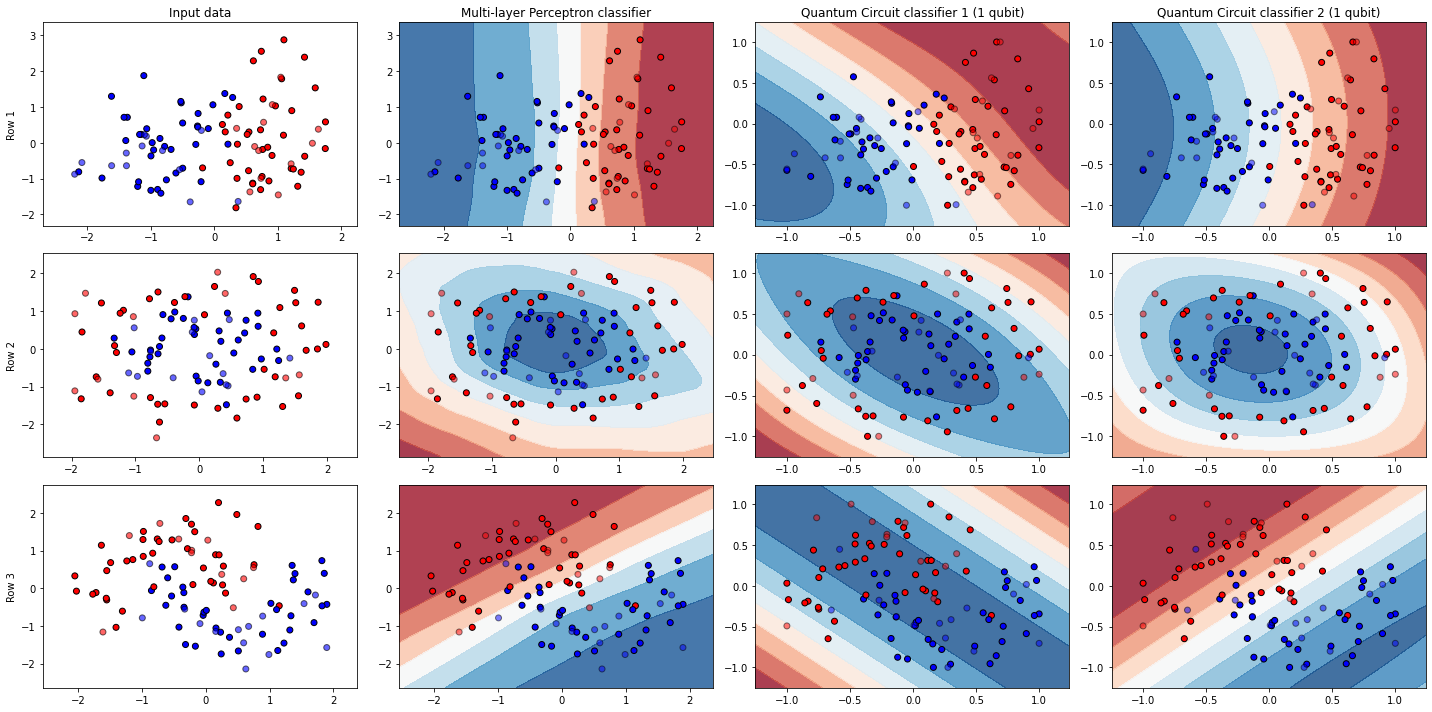

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.7145636 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     2 | Cost: 1.6490810 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     3 | Cost: 1.5626162 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     4 | Cost: 1.4397046 | Acc train: 0.5466667 | Acc val: 0.5600000 | Acc all: 0.5400000 
Iter:     5 | Cost: 1.3164831 | Acc train: 0.5733333 | Acc val: 0.6400000 | Acc all: 0.5700000 
Iter:     6 | Cost: 1.1757578 | Acc train: 0.5866667 | Acc val: 0.6400000 | Acc all: 0.5800000 
Iter:     7 | Cost: 1.0519091 | Acc train: 0.6000000 | Acc val: 0.6800000 | Acc all: 0.6000000 
Iter:     8 | Cost: 0.9347687 | Acc train: 0.6400000 | Acc val: 0.7200000 | Acc all: 0.6400000 
Iter:     9 | Cost: 0.8429782 | Acc train: 0.6266667 | Acc val: 0.7200000 | Acc all: 0.6600000 
Iter:    10 | Cost: 0.7699969 | Acc train: 0.6666667 | Acc val: 0.8400000 | Acc all: 0.6800000 
Iter:    11 | Cost: 0.7235043 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.3885399 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     2 | Cost: 1.3138161 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     3 | Cost: 1.2383795 | Acc train: 0.5600000 | Acc val: 0.5600000 | Acc all: 0.5400000 
Iter:     4 | Cost: 1.1652638 | Acc train: 0.5600000 | Acc val: 0.5600000 | Acc all: 0.5500000 
Iter:     5 | Cost: 1.1130816 | Acc train: 0.5600000 | Acc val: 0.6000000 | Acc all: 0.5600000 
Iter:     6 | Cost: 1.0635373 | Acc train: 0.5733333 | Acc val: 0.6000000 | Acc all: 0.6000000 
Iter:     7 | Cost: 1.0241311 | Acc train: 0.6000000 | Acc val: 0.6800000 | Acc all: 0.6100000 
Iter:     8 | Cost: 0.9762608 | Acc train: 0.6000000 | Acc val: 0.6800000 | Acc all: 0.6200000 
Iter:     9 | Cost: 0.9296549 | Acc train: 0.6400000 | Acc val: 0.6400000 | Acc all: 0.6500000 
Iter:    10 | Cost: 0.8977348 | Acc train: 0.6800000 | Acc val: 0.6400000 | Acc all: 0.6400000 
Iter:    11 | Cost: 0.8781928 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6689692 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.6065375 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.5477780 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.4623243 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     5 | Cost: 1.3735529 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     6 | Cost: 1.2859421 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     7 | Cost: 1.2073516 | Acc train: 0.5066667 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     8 | Cost: 1.1371088 | Acc train: 0.5600000 | Acc val: 0.6000000 | Acc all: 0.5500000 
Iter:     9 | Cost: 1.0798865 | Acc train: 0.5733333 | Acc val: 0.5600000 | Acc all: 0.5900000 
Iter:    10 | Cost: 1.0442548 | Acc train: 0.5466667 | Acc val: 0.5600000 | Acc all: 0.5700000 
Iter:    11 | Cost: 1.0217135 | Acc trai

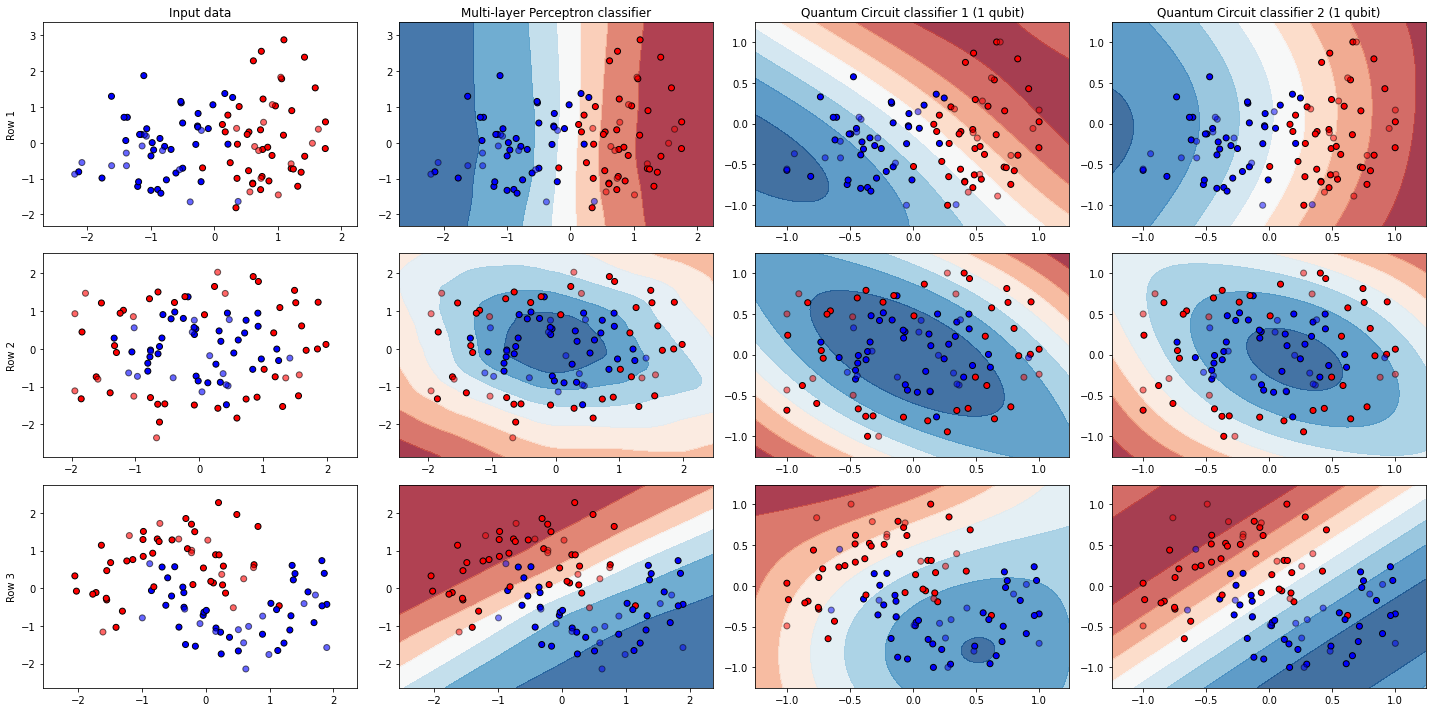

scores: [[[0.96 0.6  0.84]
  [0.96 0.6  0.84]
  [0.96 0.6  0.84]
  [0.96 0.6  0.84]
  [0.96 0.6  0.84]
  [0.96 0.6  0.84]
  [0.96 0.6  0.84]
  [0.96 0.6  0.84]
  [0.96 0.6  0.84]
  [0.96 0.6  0.84]
  [0.96 0.6  0.84]
  [0.96 0.6  0.84]
  [0.96 0.6  0.84]]

 [[0.92 0.84 0.84]
  [0.88 0.76 0.6 ]
  [0.92 0.8  0.52]
  [0.96 0.84 0.44]
  [0.76 0.8  0.48]
  [0.92 0.8  0.44]
  [0.92 0.72 0.6 ]
  [0.96 0.92 0.48]
  [0.88 0.8  0.44]
  [0.96 0.72 0.44]
  [0.92 0.68 0.8 ]
  [0.96 0.8  0.56]
  [0.84 0.8  0.84]]

 [[0.96 0.6  0.84]
  [0.88 0.68 0.84]
  [0.96 0.6  0.84]
  [0.96 0.8  0.84]
  [0.92 0.92 0.84]
  [0.92 0.8  0.84]
  [0.96 0.84 0.8 ]
  [0.92 0.76 0.84]
  [0.96 0.76 0.84]
  [0.92 0.88 0.8 ]
  [0.96 0.68 0.8 ]
  [0.92 0.76 0.84]
  [0.96 0.84 0.76]]]


In [10]:
halfPi = pi/2
# h = 0.02  # step size in the mesh
h = 0.03  # step size in the mesh
n_samples = 100

names = [
    "Multi-layer Perceptron classifier",
    # "Linear SVM",
    # "Quantum classifier circuit 1",
    "Quantum Circuit classifier 1 (1 qubit)",
    "Quantum Circuit classifier 2 (1 qubit)",
]

classifiers = [
  MLPClassifier(random_state=1, max_iter=max_iterations, 
                    solver="sgd", nesterovs_momentum=True),
  # SVC(kernel="linear", C=0.025),
  # [vc_quantum, vc_classifier_1, init_weights_1, circuit_1],
  [vc_quantum, vc_classifier_2, init_weights_2, circuit_2],
  [vc_quantum, vc_classifier_3, init_weights_3, circuit_3],
]

X, y = make_classification(
    n_samples=n_samples,
    n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1
)
rng = numpy.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [
    linearly_separable,
    make_circles(n_samples=n_samples, noise=0.2, factor=0.5, random_state=1),
    make_moons(n_samples=n_samples, noise=0.3, random_state=0),
]

# initalize scores array
scores = np.zeros(shape=(len(classifiers),loop_count,len(datasets)))

#############
# Main Loop #
#############
for l_count in range(loop_count):
  figure = plt.figure(figsize=(20, 10))
  # Figure: set white background
  figure.patch.set_facecolor('xkcd:white')

  i = 1
  # iterate over datasets
  for ds_cnt, ds in enumerate(datasets):
      # preprocess dataset, split into training and test part
      X, y = ds
      
      X = StandardScaler().fit_transform(X)
      X_train, X_test, y_train, y_test = train_test_split(
          X, y, test_size=0.25, random_state=1
      )
      x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
      y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
      xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
      
      # scale data for quantum data
      y_train_quantum = np.where(y_train==0, y_train-1, y_train)
      y_test_quantum = np.where(y_test==0, y_test-1, y_test)
      y_quantum = np.where(y==0, y-1, y)
      
      scale_value=1
      X_scaled = MinMaxScaler(feature_range=(-scale_value,scale_value), copy=True).fit_transform(X)
      X_train_scaled = MinMaxScaler(feature_range=(-scale_value,scale_value), copy=True).fit_transform(X_train)
      X_test_scaled = MinMaxScaler(feature_range=(-scale_value,scale_value), copy=True).fit_transform(X_test)

      x_min_scaled, x_max_scaled = X_scaled[:, 0].min() - 0.25, X_scaled[:, 0].max() + 0.25
      y_min_scaled, y_max_scaled = X_scaled[:, 1].min() - 0.25, X_scaled[:, 1].max() + 0.25
      xx_scaled, yy_scaled = np.meshgrid(np.arange(x_min_scaled, x_max_scaled, h), np.arange(y_min_scaled, y_max_scaled, h))

      # just plot the dataset first
      cm = plt.cm.RdBu
      cm_bright = ListedColormap(["#FF0000", "#0000FF"])
      ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
      if ds_cnt == 0:
          ax.set_title("Input data")
      ax.set(ylabel='Row ' + str(ds_cnt+1))
      # Plot the training points
      ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
      # Plot the testing points
      ax.scatter(
          X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
      )
      ax.set_xlim(xx.min(), xx.max())
      ax.set_ylim(yy.min(), yy.max())
      #ax.set_xticks(())
      #ax.set_yticks(())
      i += 1

      classifier_count=0
      # iterate over classifiers
      for name, clf in zip(names, classifiers):
          ax = plt.subplot(len(datasets), len(classifiers) + 1, i)

          if 'Quantum' in name:
            # Quantum circuit #
            vars, score = clf[0](clf[1], clf[2], X_train_scaled, X_test_scaled, X_scaled, y_train_quantum, y_test_quantum, y_quantum)
            Z = np.array(
              [clf[1](vars, f) for f in np.c_[xx_scaled.ravel(), yy_scaled.ravel()]]
            )

            # Put the result into a color plot
            Z = Z.reshape(xx_scaled.shape)
            ax.contourf(xx_scaled, yy_scaled, Z, cmap=cm, alpha=0.8)
            
            # Plot the training points
            ax.scatter(
                X_train_scaled[:, 0], X_train_scaled[:, 1], c=y_train_quantum, cmap=cm_bright, edgecolors="k"
            )
            # Plot the testing points
            ax.scatter(
                X_test_scaled[:, 0],
                X_test_scaled[:, 1],
                c=y_test_quantum,
                cmap=cm_bright,
                edgecolors="k",
                alpha=0.5,
            )

            ax.set_xlim(xx_scaled.min(), xx_scaled.max())
            ax.set_ylim(yy_scaled.min(), yy_scaled.max())
            
            # print scores
            # ax.text(
            #   xx_scaled.max() - 0.15,
            #   yy_scaled.min() + 0.15,
            #   ("Score: %.2f" % score).lstrip("0"),
            #   size=15,
            #   horizontalalignment="right",
            # )
            
          else:
            # Classical circuits #
            clf.fit(X_train, y_train)
            score = clf.score(X_test, y_test)

            # Plot the decision boundary. For that, we will assign a color to each
            # point in the mesh [x_min, x_max]x[y_min, y_max].
            if hasattr(clf, "decision_function"):
                Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
            else:
                Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

            # Put the result into a color plot
            Z = Z.reshape(xx.shape)
            ax.contourf(xx, yy, Z, cmap=cm, alpha=0.8)
                
            # Plot the training points
            ax.scatter(
                X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
            )
            # Plot the testing points
            ax.scatter(
                X_test[:, 0],
                X_test[:, 1],
                c=y_test,
                cmap=cm_bright,
                edgecolors="k",
                alpha=0.5,
            )

            ax.set_xlim(xx.min(), xx.max())
            ax.set_ylim(yy.min(), yy.max())

            # print scores
            # ax.text(
            #   xx.max() - 0.3,
            #   yy.min() + 0.3,
            #   ("Score: %.2f" % score).lstrip("0"),
            #   size=15,
            #   horizontalalignment="right",
            # )
          
          scores[classifier_count][l_count][ds_cnt] = score
          # ax.set_xticks(())
          # ax.set_yticks(())
          if ds_cnt == 0:
              ax.set_title(name)
          i += 1
          classifier_count += 1

  plt.tight_layout()
  plt.show()

print("scores:", scores)

In [11]:
for name, clf in zip(names, classifiers):
    if 'Quantum' in name:
      print(name)
      print(clf[3].draw())


Quantum Circuit classifier 1 (1 qubit)
 0: ──RY(1.24)──Rot(-0.888, -0.0142, -0.711)──RY(1.24)──Rot(-0.651, 0.928, -0.0023)──┤ ⟨Z⟩ 

Quantum Circuit classifier 2 (1 qubit)
 0: ──RY(1.24)──Rot(0.157, -0.312, 1.23)──RX(1.24)──Rot(-1.55, -1.29, -0.00413)──┤ ⟨Z⟩ 



C:\Users\zero\anaconda3\lib\site-packages\pennylane\qnode.py:838: UserWarning: The QNode.draw method has been deprecated. Please use the qml.draw(qnode)(*args) function instead.
  warnings.warn(
